In [2]:
import matplotlib.pyplot as plt
import numpy as np
#!pip install -U numba
from numba import jit
from scipy.stats import multivariate_normal
import random as rn
import eif as iso
import scipy.ndimage
from scipy.interpolate import griddata
import numpy.ma as ma
from numpy.random import uniform, seed
import time
import eif_old as iso2
import seaborn as sb
from sklearn.ensemble import IsolationForest

In [3]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.insert(0, "../")
import eif_new as iso_new

In [343]:
# Create data
mean = [0, 0, 0 ]
cov = [[1, 0, 0.], [0, 0.1, 0.0], [0,0,1]]  # diagonal covariance
Nobjs = 5000
np.random.seed(1)
x, y, z = np.random.multivariate_normal(mean, cov, Nobjs).T
# Add manual outlier
x[0] = 3.3
y[0] = 3.3
z[0] = 3.3
X = np.array([x,y,z]).T

In [5]:
# Generate train data
#X = 0.3 * np.random.randn(1000, 10)

In [344]:
rng = 42
Ntrees = 500
Nsamples = 256

In [347]:
# scikit learn solution
ss = time.time()
F0 = IsolationForest(n_estimators=Ntrees, max_samples=Nsamples, random_state=rng).fit(X)
S0 = F0.score_samples(X)*-1
ee = time.time()
print('{:.3f} sec, Scikit Learn'.format(ee-ss))

0.947 sec, Scikit Learn


In [348]:
ss = time.time()
F1 = iso.iForest(X, ntrees=Ntrees, sample_size=Nsamples, ExtensionLevel=0, seed=rng)
S1 = F1.compute_paths(X_in=X)
ee = time.time()
print('{:.3f} sec, EIF Cython Version'.format(ee-ss))

1.355 sec, EIF Cython Version


In [349]:
ss = time.time()
F2 = iso2.iForest(X, ntrees=Ntrees, sample_size=Nsamples, ExtensionLevel=0)
S2 = F2.compute_paths(X_in=X)
ee = time.time()
print('{:.3f} sec, EIF Old Python Version'.format(ee-ss)) # 422 sec vs 15 new

44.257 sec, EIF Old Python Version


In [345]:
import eif_new as iso_new
ss = time.time()
F3 = iso_new.iForest(ntrees=Ntrees, sample=Nsamples, exlevel=0, random_state=rng).fit(X)
S3 = F3.compute_paths(X)
ee = time.time()
print('{:.3f} sec, EIF New Python Version'.format(ee-ss)) # 6.309 sec, EIF New Python Version
# 3.402 sec, EIF New Python Version score_samples0
# 5.821 sec, EIF New Python Version score_samples
# 2.097 sec, EIF New Python Version score_samples1 5000x3

2.184 sec, EIF New Python Version


Text(0.5, 0, 'Scores')

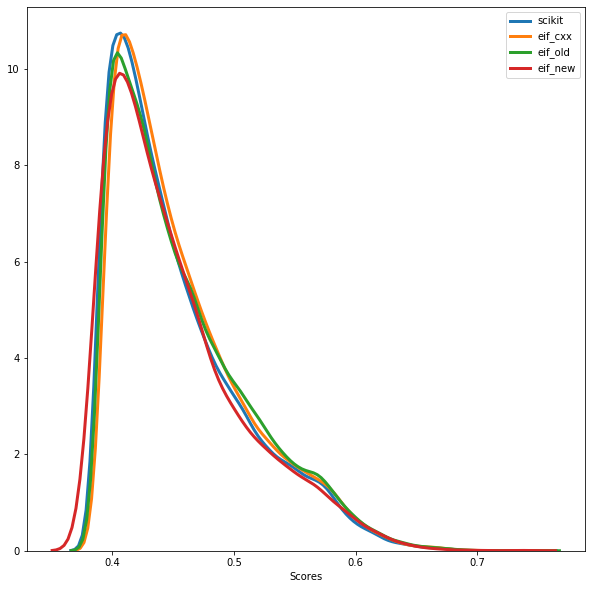

In [346]:
plt.figure(figsize=(10,10))
sb.kdeplot(S0, lw=3, label='scikit', clip=(0.35, 0.8))
sb.kdeplot(S1, lw=3, label='eif_cxx', clip=(0.35, 0.8))
sb.kdeplot(S2, lw=3, label='eif_old', clip=(0.35, 0.8))
sb.kdeplot(S3, lw=3, label='eif_new', clip=(0.35, 0.8))
plt.legend(loc=0)
plt.xlabel('Scores')

In [107]:
import joblib, os
from datetime import datetime
ext = "jbl"

t0 = datetime.now()
jbl_fn = "eif_new.%s"%ext
joblib.dump(F3, jbl_fn)
dt = datetime.now()-t0
print("%s %.2f Mb"%(dt, os.stat(jbl_fn).st_size/1024**2)) # 0:00:00.877536 0.56 Mb
# 0:00:00.407903 0.28 Mb f2 0.44 Mb f4
# 0:00:00.079145 5.49 Mb f4 u2
# 0:00:00.079248 6.95 Mb f4 i4

0:00:00.082970 5.49 Mb


In [80]:
t0 = datetime.now()
jbl_fn = "eif_old.%s"%ext
joblib.dump(F2, jbl_fn)
dt = datetime.now()-t0
print("%s %.2f Mb"%(dt, os.stat(jbl_fn).st_size/1024**2)) #0:00:32.724675 6.83 Mb
# 0:00:17.224409 3.54 Mb
# 0:00:08.227051 42.72 Mb no compression

0:00:08.227051 42.72 Mb


In [356]:
import eif_new as iso_new
F3 = iso_new.iForest(ntrees=Ntrees, sample=Nsamples, random_state=rng, exlevel=0).fit(X)
#S3 = F3.compute_paths(X)

In [357]:
%timeit iso_new.iForest(ntrees=Ntrees, sample=Nsamples, random_state=rng, exlevel=0).fit(X) #X.shape[1]-1)
%timeit F3.compute_paths(X)
# 749 ms ± 3.63 ms per loop (mean ± std. dev. of 7 runs, 1 loop each) exlevel=0
# 361 ms ± 4.18 ms per loop (mean ± std. dev. of 7 runs, 1 loop each) without p *min-max

# 2.46 s ± 1.84 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
# 1.75 s ± 5.51 ms per loop (mean ± std. dev. of 7 runs, 1 loop each) nonzero instead of argwhere
# 1.65 s ± 17 ms per loop (mean ± std. dev. of 7 runs, 1 loop each) without nonzero
# 1.36 s ± 4.45 ms per loop (mean ± std. dev. of 7 runs, 1 loop each) X.dot for all nodes
# 1.99 s ± 126 ms per loop (mean ± std. dev. of 7 runs, 1 loop each) get_paths0

# 752 ms ± 10.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each) exlevel=2
# 2.48 s ± 22.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each) 

#707 ms ± 5.07 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
#1.51 s ± 7.27 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


698 ms ± 1.42 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
1.52 s ± 6.36 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [340]:
def c_factor(n):
    return np.sum(2.0*(np.log(n-1)+0.5772156649) - (2.0*(n-1.)/(n*1.0)))

self = F3
S = np.zeros(X.shape[0])
trees = np.array([t.nodes for t in self.Trees])
#n, pdotn, left, right, sizes = trees["n"], trees["pdotn"], trees["left"], trees["right"], trees["size"]
n, pdotn, left, right, sizes = trees[["n", "pdotn", "left", "right", "size"]]

for xi in range(1): #X.shape[0]):
    ni = np.where(X[xi].dot(n[:, 0].T) < pdotn[:, 0], left[:, 0].T, right[:, 0].T)
    tidx = np.arange(trees.shape[0])
    for e in range(1, self.limit):
        w = X[xi].dot(n[tidx, ni].T) < pdotn[tidx, ni]
        ni = np.where(w, left[tidx, ni].T, right[tidx, ni].T)
        S[xi] += e*(ni==0).sum()
        print(e, (ni==0).sum(), S[xi], len(ni))
        tidx, ni = tidx[ni>0], ni[ni>0]
    # the size matters only at terminal nodes
    size = sizes[tidx, ni]
    S[xi] += self.limit*len(ni) + c_factor(size[size>1])#.sum()
    print(self.limit, (ni==0).sum(), S[xi], len(ni), size)

ValueError: too many values to unpack (expected 5)

In [359]:
def score_samples_without_childidx(X, trees, limit=8):
    S = np.zeros(X.shape[0])
    n, pdotn, sizes = trees["n"], trees["pdotn"], trees["size"]
    #powers = np.power(2, np.arange(limit+1))
    for xi in range(X.shape[0]):
        e = 0
        ni = np.zeros(len(trees), dtype='int')
        w = X[xi].dot(n[:, 0].T) < pdotn[:, 0]
        ni[w] += 1
        ni[~w] += 2**(limit-e)
        tidx = np.arange(trees.shape[0])
        for e in range(1, limit):
            w = X[xi].dot(n[tidx, ni].T) < pdotn[tidx, ni]
            ni[w] += 1
            ni[~w] += 2**(limit-e)
            sel = sizes[tidx, ni]>1
            S[xi] += e*(~sel).sum()
            tidx, ni = tidx[sel], ni[sel]
        # the size matters only at terminal nodes
        size = sizes[tidx, ni]
        S[xi] += limit*len(ni) + c_factor(size[size>1])#.sum()
    return S * 1. / len(trees)

%timeit score_samples_without_childidx(X, trees)

1.68 s ± 5.81 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [306]:
S = F3.score_samples(X); S

array([0.97761337, 0.66105967, 0.51744501, ..., 0.6299805 , 0.55715247,
       0.43243751])

In [307]:
S1 = F3.score_samples1(X); S1

array([0.74400223, 0.56587012, 0.4988135 , ..., 0.54653904, 0.5134962 ,
       0.44586648])

In [87]:
trees = np.array([t.nodes for t in F3.Trees]); trees.flags, trees.dtype

(  C_CONTIGUOUS : True
   F_CONTIGUOUS : False
   OWNDATA : True
   WRITEABLE : True
   ALIGNED : True
   WRITEBACKIFCOPY : False
   UPDATEIFCOPY : False,
 dtype([('n', '<f4', (3,)), ('pdotn', '<f4'), ('left', '<u2'), ('right', '<u2'), ('size', '<u2')]))

In [69]:
trees = np.array([t.nodes for t in F3.Trees]); trees.flags, trees.dtype
#%timeit trees = np.array([t.nodes for t in F3.Trees]) #556 µs ± 998 ns per loop (mean ± std. dev. of 7 runs, 1000 loops each)

(  C_CONTIGUOUS : True
   F_CONTIGUOUS : False
   OWNDATA : True
   WRITEABLE : True
   ALIGNED : True
   WRITEBACKIFCOPY : False
   UPDATEIFCOPY : False,
 dtype([('n', '<f2', (3,)), ('pdotn', '<f2'), ('left', '<u2'), ('right', '<u2'), ('size', '<u2'), ('e', 'u1')]))

In [11]:
w = X.dot(trees[:, 0]["n"].T) < trees[:, 0]["pdotn"]
%timeit X.dot(trees[:, 0]["n"].T) < trees[:, 0]["pdotn"] #4.7 ms ± 73.7 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
%timeit [X.dot(t.nodes["n"][0].T) < t.nodes["pdotn"][0] for t in F3.Trees] #7.74 ms ± 65.8 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)

4.87 ms ± 74.1 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
7.93 ms ± 57.1 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [357]:
xi = ni = 0
tidx = np.arange(len(trees))
ni = np.where(X[xi].dot(trees["n"][tidx, ni].T) < trees["pdotn"][tidx, ni], trees["left"][tidx, ni].T, trees["right"][tidx, ni].T)
ni.shape

(500,)

In [358]:
xi = ni = 0
tidx = np.arange(len(trees))
#ni = np.where(np.inner(X, trees["n"][tidx, ni]) < trees["pdotn"][tidx, ni], trees["left"][tidx, ni].T, trees["right"][tidx, ni].T)
ni = np.where(X.dot(trees["n"][tidx, ni].T) < trees["pdotn"][tidx, ni], trees["left"][tidx, ni].T, trees["right"][tidx, ni].T)
ni.shape

(5000, 500)

In [430]:
%prun score_samples_by_sample_pool(X, trees, 6)

In [276]:
#!pip install line_profiler
%load_ext line_profiler
%lprun -f score_samples_by_sample_all1 score_samples_by_sample_all1(X, trees)

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


In [278]:
import eif_new as iso_new
F3 = iso_new.iForest(X, ntrees=Ntrees, sample=Nsamples, random_state=rng, exlevel=0)
trees = np.array([t.nodes for t in F3.Trees]); trees.flags, trees.dtype

S = np.zeros(X.shape[0])
xi = ni = e = 0
tidx = np.arange(trees.shape[0])

In [ ]:
ni = np.where(w, trees["left"][tidx, ni].T, trees["right"][tidx, ni].T)
if e: S[xi] += e*(ni==0).sum()
print(e, (ni<1).sum(), ni)
tidx, ni = tidx[ni>0], ni[ni>0]
e += 1

In [284]:
[trees[["left", "right"]][:, 0]]
%timeit X[xi].dot(trees["n"][tidx, ni].T).shape
X[xi].shape, trees["n"][tidx, ni].T.shape, X[xi].dot(trees["n"][tidx, ni].T).shape

10 µs ± 21.3 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


((3,), (3, 500), (500,))

In [283]:
%timeit X.dot(trees["n"][tidx, ni].T).shape
X.shape, trees["n"][tidx, ni].T.shape, X.dot(trees["n"][tidx, ni].T).shape

3.78 ms ± 81.5 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


((5000, 3), (3, 500), (5000, 500))

In [279]:
#for e in range(limit):
pni = ni
w = X[xi].dot(trees["n"][tidx, ni].T) < trees["pdotn"][tidx, ni]
ni = np.where(w, trees["left"][tidx, ni].T, trees["right"][tidx, ni].T)
if e: S[xi] += e*(ni==0).sum()
print(e, (ni<1).sum(), ni)
tidx, ni = tidx[ni>0], ni[ni>0]
e += 1

0 0 [256   1 256   1   1   1   1 256   1   1   1   1   1   1 256 256 256   1
   1 256   1   1 256   1   1 256 256 256   1 256 256 256   1   1   1   1
 256   1 256   1   1   1 256   1   1   1 256   1   1   1 256   1   1   1
 256   1   1 256   1   1   1 256   1 256   1 256   1   1 256 256   1   1
   1 256 256 256   1 256   1   1   1   1 256 256 256 256   1   1 256   1
 256 256   1   1   1 256   1   1 256   1   1   1 256 256 256   1   1   1
   1   1 256   1   1   1 256   1 256   1   1   1   1   1   1   1   1   1
 256 256   1   1   1 256   1 256 256   1   1   1   1   1   1   1   1   1
 256   1   1   1 256   1 256 256   1 256   1   1   1 256   1   1   1   1
 256 256 256 256   1 256   1 256   1 256   1   1   1   1 256 256   1 256
   1   1 256 256 256   1 256 256 256   1   1 256 256 256 256 256   1   1
   1   1 256 256 256 256   1 256   1 256   1   1 256   1 256   1 256   1
 256   1   1 256 256   1   1 256 256 256   1 256 256   1   1 256 256   1
 256   1   1 256 256   1 256 256   1 256   1   

In [ ]:
# the size matters only at terminal nodes
size = trees["size"][tidx, ni]
S[xi] += e*len(ni) + c_factor(size[size>1])

In [226]:
w.shape, tidx.shape, l.shape, w.sum() #((500,), (500,), 268)
#trees["left"][tidx[w], l]

((500,), (500,), (268,), 231)

In [189]:
trees["childs"][0, l]

array([  1, 256], dtype=uint16)

In [236]:
#!pip install line_profiler
%load_ext line_profiler
%lprun -f score_samples_by_sample_all1 score_samples_by_sample_all1(X, trees)

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


In [428]:
def worker(args):
    Xi = args
    ni = 0
    S = 0
    tidx = np.arange(trees.shape[0])
    for e in range(F3.limit):
        pni = ni
        ni = np.where(Xi.dot(trees["n"][tidx, ni].T) < trees["pdotn"][tidx, ni], trees["left"][tidx, ni].T, trees["right"][tidx, ni].T)
        sel = ni>0
        if e: S += e*(~sel).sum()
        tidx, ni = tidx[sel], ni[sel]
    # the size matters only at terminal nodes
    size = trees[tidx, ni]["size"]
    S += e*len(ni) + c_factor(size[size>1]).sum()  
    return S

def score_samples_by_sample_pool(X, trees, nproc=6):
    S = np.zeros(X.shape[0])
    import multiprocessing as mp
    with mp.Pool(nproc) as p:
        iterable = (X[xi] for xi in range(X.shape[0]))
        for i, si in enumerate(p.imap(worker, iterable, 100)):
            S[i] = si
    return S/len(trees)

#%timeit score_samples_by_sample_pool(X, trees, 1) #1.96 s ± 50.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
#%timeit score_samples_by_sample_pool(X, trees, 6) #  484 ms ± 34.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
for i in range(1, 13):
    print(i)
    %timeit score_samples_by_sample_pool(X, trees, i) #  484 ms ± 34.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

1
2.02 s ± 771 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
2
1.07 s ± 49.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
3
740 ms ± 1.22 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
4
652 ms ± 626 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
5
562 ms ± 2.64 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
6
577 ms ± 19.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
7
587 ms ± 27.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
8
562 ms ± 49.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
9
543 ms ± 42.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
10
555 ms ± 43.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
11
553 ms ± 38.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
12
537 ms ± 2.07 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [431]:
%prun score_samples_by_sample(X, trees)